In [8]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle
import matplotlib.pyplot as plt

# For which test case do we plot?
`swe` is the shallow water vortex, `euler` the Euler vortex and `rb` the rising bubble.

`output_anim` if True, outputs the evolution of the divergence of the velocity fields, $\nabla \cdot \mathbf{u}$.

In [13]:
swe = False
euler = True
rb = False

output_all = False # get scale analysis for Euler vortex, with rhou and rhov assimilated or with ALL quantities assimilated?
output_anim = False

In [14]:
def load(base_fn,Nx,Ny,et,Nz=None):
    pydir = '../../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    return tc, tags

if swe:
    base_fn = 'output_swe_vortex'
    Nx, Ny, Nz = 64, 1, 64
    et = 3.0
    tc, tags = load(base_fn,Nx,Ny,et,Nz)
    
    attr_labels = pt.swe_labels()
    attributes = ['rho','rhou','rhow']
    obs_attrs = 'rhou_rhow'
    aux = 'wda'
    aux_ref = ''
    lbl = 'swe'
    times = np.arange(0.0,3.01,0.01)[1:]
    da_times = np.arange(0.0,3.25,0.25)[1:]
    times, da_times = np.around(times, 2), np.around(da_times, 2)
    
    p_ref = 1.0 # unit of contours in [m]

elif euler:
    base_fn = "output_travelling_vortex"
    Nx, Ny = 64, 64
    et = 3.0
    tc, tags = load(base_fn,Nx,Ny,et)
    
    attr_labels = pt.labels()
    attributes = ['rho','rhou','rhov']
    obs_attrs = 'rhou_rhov'
    if output_all == True:
        obs_attrs = 'all'
    aux = 'wda'
    aux_ref = ''
    lbl = 'euler'
    times = np.arange(0.0,3.01,0.01)[1:]
    da_times = np.arange(0.0,3.25,0.25)[1:]
    times, da_times = np.around(times, 2), np.around(da_times, 2)

    p_ref = 1e+2 # unit of contours in [x kPa]
    
elif rb:
    base_fn = "output_rising_bubble"
    Nx, Ny = 160,80
    et = 1.0
    tc, tags = load(base_fn,Nx,Ny,et)
    
    attr_labels = pt.labels()
    attributes = ['rho','rhou','rhov']
    obs_attrs = 'rhou_rhov'
    aux = 'wda_CFLfixed'
    aux_ref = '_CFLfixed'
    lbl = 'rb'
    times = np.arange(1.0,10.1,0.1)[1:]/10.0
    da_times = np.arange(5.0,10.5,0.5)/10.0
    times, da_times = np.around(times, 2), np.around(da_times, 2)

    p_ref = 8.61 * 1e1 # unit of contours in [kPa]
    
sfx_ref = 'noda%s_ib-0' %aux_ref
# lbl_ref = 'Ens. w/o DA'
lbl_ref = 'EnNoDA'

sfx0 = 'wdawloc_%s_%s_ib-0' %(obs_attrs,aux)
lbl0 = r'EnDA'
#     ens_1_label = r'Ens. w/ DA'

sfx1 = tc.cb_suffix(1,0, '%s' %(sfx0))
lbl1 = r'EnDAB'
#     ens_2_label = r'Ens. w/ DA+Blending'
print(sfx0)

# Ensemble size is the same across all test cases
N = 10
tag = tags[9]

wdawloc_rhou_rhov_wda_ib-0


p_ref / rho_ref = 86220.0
c^2 = 86220.00000000001
0.015625 0.015625
(68, 68)
ens 0
ens 1
ens 2


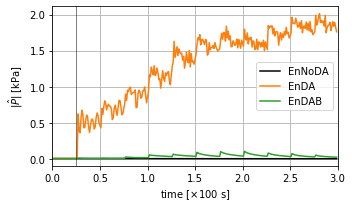

In [15]:
# load pickled instances of data used in simulation
fn_pickle = tc.get_filename(N,sfx0,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
file.close()

# get dimensionless grid-size
dx = np.diff(elem.x)[0]
if swe:
    dy = np.diff(elem.z)[0]
else:
    dy = np.diff(elem.y)[0]
    
# remove all outputs that are right after the assimilation of data,
# since we want to capture the velocities that go into the flow fields.
times = np.setdiff1d(times,da_times)

class oo(object): pass
ens0_oo = oo()
ens1_oo = oo()
ens_ref_oo = oo()

# load ensembles
def get_ens_by_attr(times, N, attributes, sfx, tag=tag, inner=True):
    obj = oo()
    for attribute in attributes:
        ens = tc.get_ensemble(times, N, attribute, sfx, tag=tag, inner=False)#[-1]

        # project quasi-3D SWE arrays to 2D:
        # index 0 indexes time, 1 indexes ensemble members,
        # and the three remaining indices are x,y,z.
        # SWE simulations are on horizontal x-z slices,
        # so we remove the y-axis.
        if swe: ens = ens[:,:,:,0,:]

        mean = np.mean(ens,axis=1)
        ens = np.append(ens,mean[:,np.newaxis,...],axis=1)
        setattr(obj,attribute,ens)
    
    # recover u and v, the velocity fields
    ens_u = getattr(obj,attributes[1]) / getattr(obj,'rho')
    ens_v = getattr(obj,attributes[2]) / getattr(obj,'rho')
    setattr(obj, 'u', ens_u)
    setattr(obj, 'v', ens_v)
    
    return obj

# helper function to get partial derivatives
def grad(arr,dd,direction,ud):
    dd *= ud.h_ref
    arr *= ud.u_ref
    # get partial derivatives
    if direction == 'x':
        axs = 0
    elif direction == 'y':
        axs = 1
    else:
        assert(0, 'direction unspported')
        
    return np.gradient(arr,dd,axis=axs)

ens0 = get_ens_by_attr(times,N,attributes,sfx0)
ens1 = get_ens_by_attr(times,N,attributes,sfx1)
ens_ref = get_ens_by_attr(times,N,attributes,sfx_ref)

enses = [ens_ref, ens0, ens1]
sfxes = [sfx_ref, sfx0, sfx1]

# recover magic numbers
if swe:
    Frsq = ud.Msq / 2
    Ma = np.sqrt(ud.Msq)
    c = ud.u_ref / Ma
    Fr = np.sqrt(Frsq)
else:
    Ma = np.sqrt(ud.Msq)
    c = ud.u_ref / Ma
    print("p_ref / rho_ref =", ud.p_ref/ ud.rho_ref)
    print("c^2 =", c**2)

arr_lst = []
barPu = np.zeros((3,len(times)))


def title_gen(frn):
    return "time = %.2f" %times[frn]

print(dx,dy)
print(ens0.u[0][0].shape)

# for each array, over all time, we calculate the scale analysis
for bb,ens in enumerate(enses):
    print("ens %i" %bb)
    arr_plt = np.empty_like(times, dtype='object')
    
    for tt,time in enumerate(times):
        us, vs = ens.u[tt], ens.v[tt]
        rho = ens.rho[tt][:,2:-2,2:-2] # remove ghost cells

        divu = np.zeros_like(us)
        divu = divu[:,2:-2,2:-2] # empty array without ghost cells
        for ii,uv in enumerate(zip(us,vs)):
            u, v = np.copy(uv[0]), np.copy(uv[1])
            # calculate divergence of the velocity fields with ghost cells
            div = grad(u,dx,'x',ud) + grad(v,dy,'y',ud)
            # take only the inner domain, i.e. without ghost cells
            divu[ii] = div[2:-2,2:-2]
        
        # put array for plotting if animation is enabled
        # this outputs plot for the 0th ensemble member
#         if output_anim: arr_plt[tt] = [[divu[0].T,'ens %i, div(u)' %bb]]
        # this outputs plot for the ensemble mean
        if output_anim: arr_plt[tt] = [[divu.mean(axis=0).T,'ens %i, div(u) mean' %bb]]
        
        # calculate scale analysis (cite the equation numbers when written)
        if swe:
            Ptu = divu * 0.5 * 11.0 * dx * ud.h_ref / (np.sqrt(9.81 * ud.d_ref))
            Ptu *= rho
            Ptu *= 100.0
        else:
            Ptu = divu * rho * c**2 * ud.rho_ref
            Ptu *=  0.5*11.0*dx * ud.h_ref * Ma / ud.u_ref
#             Ptu /= ud.p_ref
            if euler:
                Ptu /= 1000.0
            
        # get norm for the contribution from the velocity fields at each time-point
        Ptu_norm = np.array([ np.sqrt((mem**2).mean()) for mem in Ptu[:-1]]).mean()
        Ptu_norm *= 2.0/np.pi
        if swe:
            barPu[bb,tt] = Ptu_norm
        else:
            # P = p^{1/gamma}
            barPu[bb,tt] = Ptu_norm * 1.0/1.4
            
    # output an animation of the div(u) evolution if output_anim is True
    if output_anim:
        fs = (8,6) if rb else (8,8)
        a2d = pt.animator_2D(arr_plt,ncols=1,figsize=fs)
        a2d.suptitle = title_gen
        a2d.method = 'contour'
        anim = a2d.animate(interval=500, aspect='equal', method='contour')

        import matplotlib.animation as animation

        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=10, metadata=dict(artist=''), bitrate=6000)
        anim.save('./output/%s_div_ens_%i.mp4' %(lbl,bb), writer=writer)

# plotting...
t_axs = times
barPu00 = 0.0

plt.figure(figsize=(5,3))

if rb:
    plt.figure(figsize=(7.5,3.2))

plt.plot(t_axs, barPu[0] - barPu00, 'k', label=lbl_ref)
plt.plot(t_axs, barPu[1] - barPu00, 'C1', label=lbl0)
plt.plot(t_axs, barPu[2] - barPu00, 'C2', label=lbl1)

if swe:
    plt.xlabel(r'time [$\times 100$ s]', labelpad=5)
    plt.ylabel(r'$\hat{h}^\prime$ [m]')
    plt.axvline(0.25, c='k', lw=0.5)
elif euler:
    plt.xlabel(r'time $[\times 100$ s$]$')
    plt.ylabel(r'$| \hat{P} |$ [kPa]')
    plt.axvline(0.25, c='k', lw=0.5)
elif rb:
    plt.xlabel(r'time $[\times 100$ s$]$')
    plt.ylabel(r'$ | \hat{P} |$ [Pa]')
    plt.axvline(0.5, c='k', lw=0.5)
    
if rb:
    xet = 1.0
elif euler:
    xet = 3.0
plt.xlim([0, xet])
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./output/scale_analysis_%s.pdf' %lbl)
plt.show()

In [12]:
barPu_all = np.copy(barPu)

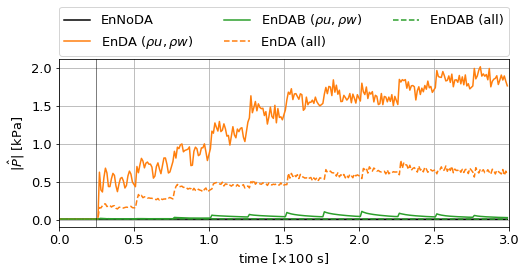

In [16]:
plt.figure(figsize=(7.5,4))

plt.rcParams.update({'font.size': 13})

plt.plot(t_axs, barPu[0] - barPu00, 'k', label=lbl_ref)
plt.plot(t_axs, barPu[1] - barPu00, 'C1', label=r'EnDA $(\rho u, \rho w)$')
plt.plot(t_axs, barPu[2] - barPu00, 'C2', label=r'EnDAB $(\rho u, \rho w)$')
plt.plot(t_axs, barPu_all[1] - barPu00, 'C1--', label=r'EnDA (all)')


# plt.plot(t_axs, barPu_all[0] - barPu00, 'k', label=lbl_ref)
plt.plot(t_axs, barPu_all[2] - barPu00, 'C2--', label=r'EnDAB (all)')

if swe:
    plt.xlabel(r'time [$\times 100$ s]', labelpad=5)
    plt.ylabel(r'$\hat{h}^\prime$ [m]')
    plt.axvline(0.25, c='k', lw=0.5)
elif euler:
    plt.xlabel(r'time $[\times 100$ s$]$')
    plt.ylabel(r'$| \hat{P} |$ [kPa]')
    plt.axvline(0.25, c='k', lw=0.5)
elif rb:
    plt.xlabel(r'time $[\times 100$ s$]$')
    plt.ylabel(r'$ | \hat{P} |$ [Pa]')
    plt.axvline(5.0, c='k', lw=0.5)
    
if rb:
    xet = 1.0
elif euler:
    xet = 3.0
plt.xlim([0, xet])
# plt.ylim([0,3.0])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.)
plt.grid()
plt.tight_layout()
plt.savefig('./output/scale_analysis_%s.pdf' %lbl)
plt.show()